**Predicting Recidivism Using Logistic Regression [Combined SMOTE and ENN]**

The notebook uses random forest classifier to train and predict recidivism using data from the state of Iowa. The cleaned dataset consists of 21,611 rows and 17 columns. One of the columns, whether an individual returned to prison within 3 years of release, is used as the label [target feature]. Five of the attributes ['Recidivism Type','Days to Recidivism','New Conviction Offense Classification','New Conviction Offense Type','New Conviction Offense Sub Type'] represent information collected for recidivist prisoners and hence are not considered with the predictor features. 

The data shows 7,027 individuals returned to prison; therefore the positive to negative class ratio is ~1 : 2. Although not as extreme as in problems in areas such as fraud detection and infant mortality, there is imbalance in the data that requires balancing the data before applying machine learning algorithms. In this notebook,I use SMOTEENN from sklearn to oversample and clean the data.

SMOTEENN over-samples the minority class by generating new synthetic samples using interpolation (SMOTE) and cleans noisy samples using ENN. 

**Import Libraries**

In [22]:
import matplotlib
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

**Load cleaned data**

In [23]:
recidivism_data = pd.read_pickle('RecidivismData_forAnalysis')

**Look at the dimension of the dataset**

In [24]:
recidivism_data.shape

(21611, 17)

**Look at the list of the attributes**

In [25]:
list(recidivism_data.columns)

['Fiscal Year Released',
 'Recidivism Reporting Year',
 'Race - Ethnicity',
 'Sex',
 'Age At Release ',
 'Convicting Offense Classification',
 'Convicting Offense Type',
 'Convicting Offense Subtype',
 'Release Type',
 'Main Supervising District',
 'Recidivism - Return to Prison',
 'Recidivism Type',
 'Days to Recidivism',
 'New Conviction Offense Classification',
 'New Conviction Offense Type',
 'New Conviction Offense Sub Type',
 'Part of Target Population']

**Drop columns of information collected after recidivism**

In [26]:
recidivism_data.drop(['Recidivism Type','Days to Recidivism','New Conviction Offense Classification','New Conviction Offense Type','New Conviction Offense Sub Type'], axis = 1, inplace = True)

In [27]:
#remove any spaces around the attribute name
recidivism_data.rename(columns=lambda x: x.strip(),inplace = True)

In [28]:
#convert "Yes"/"No" to "1"/"0" for manipulation by LogisticRegression
recidivism_data = recidivism_data.replace({"Recidivism - Return to Prison":["Yes","No"]},{"Recidivism - Return to Prison":["1","0"]})

In [29]:
categorical_attribute = ['Race - Ethnicity','Sex','Age At Release','Convicting Offense Classification',
                         'Convicting Offense Type','Convicting Offense Subtype','Release Type',
                         'Main Supervising District','Part of Target Population']

In [30]:
numerical_attribute = ['Fiscal Year Released','Recidivism Reporting Year']

In [31]:
binary_attribute = ['Recidivism - Return to Prison']

In [32]:
len(categorical_attribute), len(numerical_attribute), len(binary_attribute)

(9, 2, 1)

**Convert string type to int for numerical and binary attribute**

In [33]:
for i in numerical_attribute:
    recidivism_data['%s' % i] = recidivism_data['%s' % i].astype(int)

In [34]:
for i in binary_attribute:
    recidivism_data['%s' % i] = recidivism_data['%s' % i].astype(int)

**Encode categorical attributes**

In [35]:
df = pd.get_dummies(recidivism_data, prefix=categorical_attribute, columns=categorical_attribute)
df.shape

(21611, 91)

In [36]:
df['Recidivism - Return to Prison'].value_counts()

0    14584
1     7027
Name: Recidivism - Return to Prison, dtype: int64

In [37]:
df_features = list(df.columns)
df_features.remove('Recidivism - Return to Prison')
df_features.remove('Fiscal Year Released')
df_features.remove('Recidivism Reporting Year')

In [38]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import classification_report
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN

In [39]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [40]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8,
               test_size=0.2):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    X_resampled, y_resampled = SMOTEENN().fit_sample(X, y)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_resampled, y_resampled, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    y_score = clf.decision_function(Xtest)
    ytrain_score = clf.decision_function(Xtrain)
    test_average_precision = average_precision_score(ytest, y_score)
    train_average_precision = average_precision_score(ytrain, ytrain_score)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    print('Average test precision score: {0:0.2f}'.format(test_average_precision))
    print('Average train precision score: {0:0.2f}'.format(train_average_precision))
    return clf, Xtrain, ytrain, Xtest, ytest,y_score,ytrain_score

In [41]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l,yscore_1,ytrain_score_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, 
                                                           df, df_features, 'Recidivism - Return to Prison',1)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


BEST PARAMS {'C': 1}
Accuracy on training data: 0.87
Accuracy on test data:     0.87
Average test precision score: 0.96
Average train precision score: 0.95


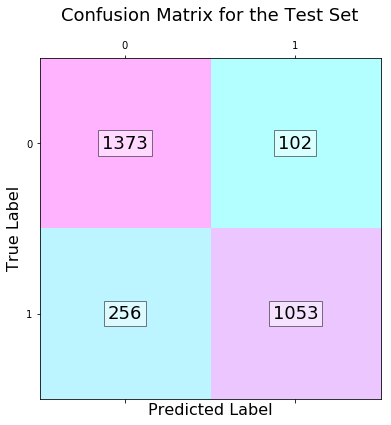

In [42]:
from matplotlib import rcParams
confmat_test = confusion_matrix(ytest_l, clf_l.predict(Xtest_l))
rcParams['axes.titlepad'] = 20 
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(confmat_test, cmap=plt.cm.cool, alpha=0.3)
for i in range(confmat_test.shape[0]):
    for j in range(confmat_test.shape[1]):
        ax.text(x=j, y=i, s=confmat_test[i, j], va='center', ha='center',fontsize=18,bbox=dict(facecolor='white', alpha=0.5))
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
plt.xlabel('Predicted Label',size=16)
plt.ylabel('True Label',size=16)
plt.title('Confusion Matrix for the Test Set',size=18)
plt.tight_layout()
plt.savefig('LR_SMOTE_ENN_Split_confusion_matrix_test.eps',format = 'eps',dpi = 1300)
plt.show()

In [43]:
SS_train = Xtrain_l.shape[0] 
SS_test = Xtest_l.shape[0]
PP_train = round(np.sum(ytrain_l)/SS_train,3)
NP_train = round(np.sum(ytrain_l == 0)/SS_train,3)
PP_test = round(np.sum(ytest_l)/SS_test,3)
NP_test = round(np.sum(ytest_l == 0)/SS_test,3)

In [44]:
TN_test, FP_test, FN_test, TP_test = confusion_matrix(ytest_l,clf_l.predict(Xtest_l)).ravel()

In [45]:
print(TN_test,TP_test,FP_test,FN_test)

1373 1053 102 256


In [46]:
TPR_test = round(TP_test/(TP_test+FN_test),3) #true positive rate (Recall)

TNR_test = round(TN_test/(TN_test+FP_test),3) #true negative rate (Specifity)

PPV_test = round(TP_test/(TP_test+FP_test),3) #positive predictive value (Precision)

NPV_test = round(TN_test/(TN_test+FN_test),3) # Negative predictive value

FPR_test = round(FP_test/(FP_test+TN_test),3) # Fall out or false positive rate

FNR_test = round(FN_test/(TP_test+FN_test),3) # False negative rate

FDR_test = round(FP_test/(TP_test+FP_test),3) # False discovery rate

ACC_test = round((TP_test+TN_test)/(TP_test+FP_test+FN_test+TN_test),3) # Overall accuracy

In [47]:
print(classification_report(ytest_l, clf_l.predict(Xtest_l)))

             precision    recall  f1-score   support

          0       0.84      0.93      0.88      1475
          1       0.91      0.80      0.85      1309

avg / total       0.88      0.87      0.87      2784



**Precision-Recall Curve**

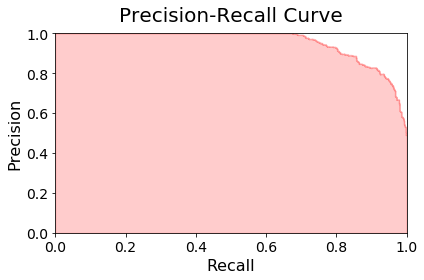

In [48]:
from sklearn.metrics import precision_recall_curve
precision_test, recall_test, _ = precision_recall_curve(ytest_l, yscore_1)
rcParams['axes.titlepad'] = 12 
plt.step(recall_test, precision_test, color='r', alpha=0.2,where='post')
plt.fill_between(recall_test, precision_test, step='post', alpha=0.2,color='r')
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
plt.xlabel('Recall',size=16)
plt.ylabel('Precision',size=16)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve',size=20)
plt.tight_layout()
plt.savefig('LR_SMOTE_ENN_Split_precision_recall_test.png',format = 'png')

In [49]:
Xtrain_l.shape, ytrain_l.shape, Xtest_l.shape, ytest_l.shape

((11135, 88), (11135,), (2784, 88), (2784,))

***Receiver Operating Characteristic***

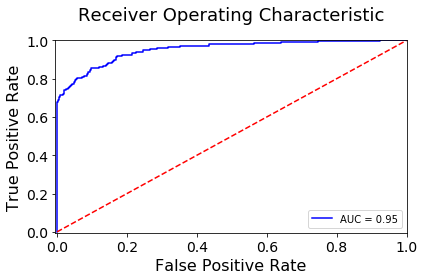

In [69]:
from sklearn.metrics import roc_curve, auc
fpr1_test, tpr1_test, _ = roc_curve(ytest_l, yscore_1)
roc_auc_test = auc(fpr1_test, tpr1_test)
plt.title('Receiver Operating Characteristic',size=18)
plt.plot(fpr1_test, tpr1_test, 'b',label='AUC = %0.2f'% roc_auc_test)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
rcParams['axes.titlepad'] = 20 
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.005,1.0])
plt.ylim([-0.005,1.0])
plt.ylabel('True Positive Rate',size=16)
plt.xlabel('False Positive Rate',size=16)
plt.tight_layout()
plt.savefig('LR_SMOTE_ENN_Split_ROC_test.eps',format = 'eps',dpi = 1300)
plt.show()

In [51]:
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(ytest_l,clf_l.predict(Xtest_l))
print(cm_test)
cmt_test = pd.DataFrame(cm_test)

[[1373  102]
 [ 256 1053]]


### Confusion matrix for training data

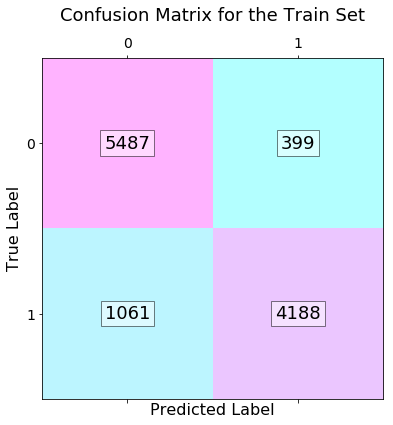

In [52]:
confmat_train = confusion_matrix(ytrain_l, clf_l.predict(Xtrain_l))
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(confmat_train, cmap=plt.cm.cool, alpha=0.3)
for i in range(confmat_train.shape[0]):
    for j in range(confmat_train.shape[1]):
        ax.text(x=j, y=i, s=confmat_train[i, j], va='center', ha='center',fontsize=18,bbox=dict(facecolor='white', alpha=0.5))
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
plt.xlabel('Predicted Label',size=16)
plt.ylabel('True Label',size=16)
plt.title('Confusion Matrix for the Train Set',size=18)
plt.tight_layout()
plt.savefig('LR_SMOTE_ENN_Split_Confusion_matrix_train.eps',format = 'eps',dpi = 1300)
plt.show()

In [53]:
TN_train,FP_train,FN_train,TP_train = confusion_matrix(ytrain_l,clf_l.predict(Xtrain_l)).ravel()

In [54]:
print(TN_train,TP_train,FP_train,FN_train)

5487 4188 399 1061


In [55]:
TPR_train = round(TP_train/(TP_train+FN_train),3) #true positive rate (Recall)

TNR_train = round(TN_train/(TN_train+FP_train),3) #true negative rate (Specifity)

PPV_train = round(TP_train/(TP_train+FP_train),3) #positive predictive value (Precision)

NPV_train = round(TN_train/(TN_train+FN_train),3) # Negative predictive value

FPR_train = round(FP_train/(FP_train+TN_train),3) # Fall out or false positive rate

FNR_train = round(FN_train/(TP_train+FN_train),3) # False negative rate

FDR_train = round(FP_train/(TP_train+FP_train),3) # False discovery rate

ACC_train = round((TP_train+TN_train)/(TP_train+FP_train+FN_train+TN_train),3) # Overall accuracy

In [56]:
print(classification_report(ytrain_l, clf_l.predict(Xtrain_l)))

             precision    recall  f1-score   support

          0       0.84      0.93      0.88      5886
          1       0.91      0.80      0.85      5249

avg / total       0.87      0.87      0.87     11135



**Precision-Recall Curve**

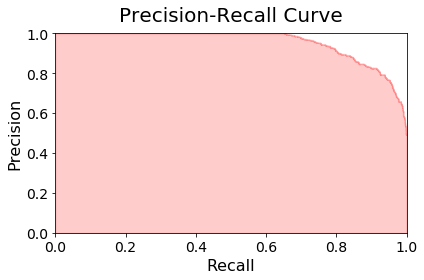

In [57]:
from sklearn.metrics import precision_recall_curve
precision_train, recall_train, _ = precision_recall_curve(ytrain_l, ytrain_score_l)
rcParams['axes.titlepad'] = 12 
plt.step(recall_train, precision_train, color='r', alpha=0.2,where='post')
plt.fill_between(recall_train, precision_train, step='post', alpha=0.2,color='r')
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
plt.xlabel('Recall',size=16)
plt.ylabel('Precision',size=16)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve',size=20)
plt.tight_layout()
plt.savefig('LR_SMOTE_ENN_Split_Precision_Recall_train.png',format = 'png')

***Receiver Operating Characteristic***

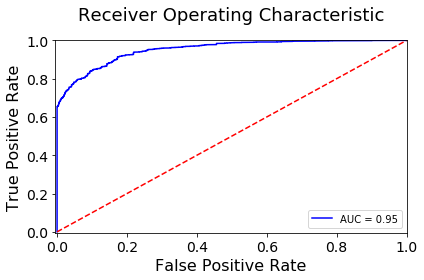

In [70]:
fpr1_train, tpr1_train, _ = roc_curve(ytrain_l, ytrain_score_l)
roc_auc_train = auc(fpr1_train, tpr1_train)
plt.title('Receiver Operating Characteristic',size=18)
plt.plot(fpr1_train, tpr1_train, 'b',label='AUC = %0.2f'% roc_auc_train)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
rcParams['axes.titlepad'] = 20 
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.005,1.0])
plt.ylim([-0.005,1.0])
plt.ylabel('True Positive Rate',size=16)
plt.xlabel('False Positive Rate',size=16)
plt.tight_layout()
plt.savefig('LR_SMOTE_ENN_Split_ROC_train.eps',format = 'eps',dpi = 1300)
plt.show()

In [59]:
performance_data = np.array([['','PP','NP','SS','ACCURACY','PRECISION','RECALL','TNR'],
                             ['Training Set',PP_train,NP_train,SS_train,ACC_train,PPV_train,TPR_train,TNR_train],
                             ['Test Set',PP_test,NP_test,SS_test,ACC_test,PPV_test,TPR_test,TNR_test]])

In [60]:
performance_table = pd.DataFrame(data=performance_data[1:,1:],
                      index=performance_data[1:,0],
                      columns=performance_data[0,1:])

In [61]:

performance_table

,PP,NP,SS,ACCURACY,PRECISION,RECALL,TNR
Training Set,0.471,0.529,11135,0.869,0.913,0.798,0.932
Test Set,0.47,0.53,2784,0.871,0.912,0.804,0.931


In [62]:
clf_l.coef_.shape

(1, 88)

In [63]:
coefficients = pd.concat([pd.DataFrame(df_features),pd.DataFrame(np.transpose(clf_l.coef_))], axis = 1)

In [64]:
coefficients.columns = ['attributes','coefficient']
coefficients['abs_coefficient'] = coefficients['coefficient'].abs()

In [65]:
coefficients.sort_values(by='abs_coefficient', ascending=False).head(20)

,attributes,coefficient,abs_coefficient
46,Convicting Offense Subtype_Murder/Manslaughter,-3.558538,3.558538
84,Main Supervising District_Interstate Compact,-3.484058,3.484058
85,Main Supervising District_Unknown,-3.411642,3.411642
83,Main Supervising District_ISC,-2.749562,2.749562
53,Convicting Offense Subtype_Robbery,-2.728070,2.728070
15,Age At Release_55 and Older,-2.373257,2.373257
71,Release Type_Paroled w/Immediate Discharge,-1.966736,1.966736
51,Convicting Offense Subtype_Other Violent,-1.882648,1.882648
39,Convicting Offense Subtype_Arson,-1.802547,1.802547
55,Convicting Offense Subtype_Sex Offender Regist...,-1.745340,1.745340
